**Options Pricing**
**Pricing ATM European call and put options using the Cox–Ross–Rubinstein (CRR) binomial tree.**
**Question 1**
Price an ATM European call and put using a binomial tree:
- Choose the number of steps in the tree you see convenient to achieve reliable estimates.
- Briefly describe the overall process, as well as a reason why you choose that number of steps in the
tree.

Given parameters

So = 100, K = 100, r = 5% = 0.05, σ = 20%, T = 3 months = 0.25 years



In [7]:
import math
import pprint as pp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from scipy.stats import norm
from math import log, sqrt, exp
import logging

# Setup logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')


In [8]:
S0 = 100.0
K = 100.0  # ATM
r = 0.05   # annual risk-free rate
T = 0.25   # 3 months = 0.25 years
sigma1 = 0.20
sigma2 = 0.25  # for vega comparison (5% absolute increase)

def binomial_european_option(S0, K, r, T, sigma, N=200, option_type='call'):
    dt = T / N
    u = math.exp(sigma * math.sqrt(dt))
    d = 1.0 / u
    disc = math.exp(-r * dt)
    p = (math.exp(r * dt) - d) / (u - d)
    
    # terminal prices
    prices = [S0 * (u**j) * (d**(N-j)) for j in range(N+1)]
    
    if option_type == 'call':
        values = [max(pn - K, 0.0) for pn in prices]
    else:
        values = [max(K - pn, 0.0) for pn in prices]

    # backward induction
    for i in range(N-1, -1, -1):
        values = [disc * (p * values[j+1] + (1-p) * values[j]) for j in range(i+1)]
    return values[0], u, d, p, dt

# Run with two choices of N to show convergence
results = []
for N in [50, 100, 200]:
    C, u, d, p, dt = binomial_european_option(S0, K, r, T, sigma1, N=N, option_type='call')
    P, _, _, _, _ = binomial_european_option(S0, K, r, T, sigma1, N=N, option_type='put')
    results.append({'N': N, 'Call Price': C, 'Put Price': P})

formatted_results = []
for item in results:
    formatted_results.append({
        'N': item['N'],
        'Call Price': f"{item['Call Price']:.3f}",
        'Put Price': f"{item['Put Price']:.3f}"
    })

pp.pprint(formatted_results)

[{'Call Price': '4.595', 'N': 50, 'Put Price': '3.353'},
 {'Call Price': '4.605', 'N': 100, 'Put Price': '3.363'},
 {'Call Price': '4.610', 'N': 200, 'Put Price': '3.368'}]


**Comments**

- European call and put options were priced using a recombining binomial tree with step counts N = 50, 100, 200. As the number of steps increased, both option prices converged to stable values, approximately 4.61 for the call and 3.37 for the put. This convergence shows that the binomial method is approaching the continuous-time limit, consistent with the theoretical convergence of the binomial model to the Black–Scholes framework.

- A final step size of N = 200 was chosen because it provides a strong balance between accuracy and computational efficiency. At this resolution, prices stabilize to within 2–3 decimal places, which is particularly important for at-the-money options that are sensitive near the strike. Given the short maturity of T = 0.25 years, N = 200 delivers high precision without unnecessary computational cost, making it suitable for both academic and practical applications.

**Black-Scholes Pricing Model with Greeks**

Implementation of the **Black-Scholes model** for pricing European options and computing their sensitivities, known as **Greeks**.

**Assumptions of the Black-Scholes Model**

1. The stock price follows a **geometric Brownian motion** with constant drift $\mu$ and volatility $\sigma$.
2. The risk-free interest rate $r$ is constant and known.
3. No dividends are paid on the underlying asset.
4. Markets are frictionless (no transaction costs, no arbitrage, continuous trading).
5. The option is **European-style**, exercisable only at maturity $T$.

**Black Scholes Option Class**

In [9]:
class EuropeanOption:
    def __init__(self, S, K, T, r, sigma, option_type='call'):
        self.S = S          # Spot price
        self.K = K          # Strike price
        self.T = T          # Time to maturity (in years)
        self.r = r          # Risk-free rate
        self.sigma = sigma  # Volatility
        self.option_type = option_type.lower()

        self._d1 = (np.log(self.S / self.K) + (self.r + 0.5 * self.sigma ** 2) * self.T) / (self.sigma * np.sqrt(self.T))
        self._d2 = self._d1 - self.sigma * np.sqrt(self.T)

        logging.info(f'Initialized {self.option_type} option with S={self.S}, K={self.K}, T={self.T}, r={self.r}, sigma={self.sigma}')

    def price(self):
        if self.option_type == 'call':
            return self.S * norm.cdf(self._d1) - self.K * np.exp(-self.r * self.T) * norm.cdf(self._d2)
        elif self.option_type == 'put':
            return self.K * np.exp(-self.r * self.T) * norm.cdf(-self._d2) - self.S * norm.cdf(-self._d1)
        else:
            raise ValueError("option_type must be 'call' or 'put'")

    def greeks(self):
        delta = norm.cdf(self._d1) if self.option_type == 'call' else norm.cdf(self._d1) - 1
        gamma = norm.pdf(self._d1) / (self.S * self.sigma * np.sqrt(self.T))
        vega = self.S * norm.pdf(self._d1) * np.sqrt(self.T)
        theta = self._theta()
        rho = self._rho()

        return {'Delta': delta, 'Gamma': gamma, 'Vega': vega / 100, 'Theta': theta / 365, 'Rho': rho / 100}

    def _theta(self):
        term1 = - (self.S * norm.pdf(self._d1) * self.sigma) / (2 * np.sqrt(self.T))
        if self.option_type == 'call':
            term2 = self.r * self.K * np.exp(-self.r * self.T) * norm.cdf(self._d2)
            return term1 - term2
        else:
            term2 = self.r * self.K * np.exp(-self.r * self.T) * norm.cdf(-self._d2)
            return term1 + term2

    def _rho(self):
        if self.option_type == 'call':
            return self.K * self.T * np.exp(-self.r * self.T) * norm.cdf(self._d2)
        else:
            return -self.K * self.T * np.exp(-self.r * self.T) * norm.cdf(-self._d2)


**Visualizing the Option Price vs Spot Price**

In [12]:
def plot_option_vs_spot(K, T, r, sigma, option_type = 'call'):
    S_range = np.linspace(0.5 * K, 1.5 * K, 100)
    prices = []
    
    for S in S_range:
        opt = EuropeanOption(S, K, T, r, sigma, option_type)
        prices.append(opt.price())
    
    plt.figure(figsize=(8, 5))
    plt.plot(S_range, prices, label=f'{option_type.capitalize()} Price')
    plt.axvline(K, color='gray', linestyle='--', label='Strike')
    plt.title(f'{option_type.capitalize()} Option Price vs Spot Price')
    plt.xlabel('Spot Price')
    plt.ylabel('Option Price')
    plt.legend()
    plt.grid(True)
    plt.show()

2025-07-27 00:23:16,049 - INFO - Initialized call option with S=50.0, K=100, T=1, r=0.05, sigma=0.2
2025-07-27 00:23:16,060 - INFO - Initialized call option with S=51.01010101010101, K=100, T=1, r=0.05, sigma=0.2
2025-07-27 00:23:16,061 - INFO - Initialized call option with S=52.02020202020202, K=100, T=1, r=0.05, sigma=0.2
2025-07-27 00:23:16,062 - INFO - Initialized call option with S=53.03030303030303, K=100, T=1, r=0.05, sigma=0.2
2025-07-27 00:23:16,062 - INFO - Initialized call option with S=54.04040404040404, K=100, T=1, r=0.05, sigma=0.2


2025-07-27 00:23:16,063 - INFO - Initialized call option with S=55.05050505050505, K=100, T=1, r=0.05, sigma=0.2
2025-07-27 00:23:16,064 - INFO - Initialized call option with S=56.06060606060606, K=100, T=1, r=0.05, sigma=0.2
2025-07-27 00:23:16,066 - INFO - Initialized call option with S=57.07070707070707, K=100, T=1, r=0.05, sigma=0.2
2025-07-27 00:23:16,067 - INFO - Initialized call option with S=58.08080808080808, K=100, T=1, r=0.05, sigma=0.2
2025-07-27 00:23:16,068 - INFO - Initialized call option with S=59.09090909090909, K=100, T=1, r=0.05, sigma=0.2
2025-07-27 00:23:16,069 - INFO - Initialized call option with S=60.101010101010104, K=100, T=1, r=0.05, sigma=0.2
2025-07-27 00:23:16,070 - INFO - Initialized call option with S=61.111111111111114, K=100, T=1, r=0.05, sigma=0.2
2025-07-27 00:23:16,071 - INFO - Initialized call option with S=62.121212121212125, K=100, T=1, r=0.05, sigma=0.2
2025-07-27 00:23:16,072 - INFO - Initialized call option with S=63.131313131313135, K=100, T=

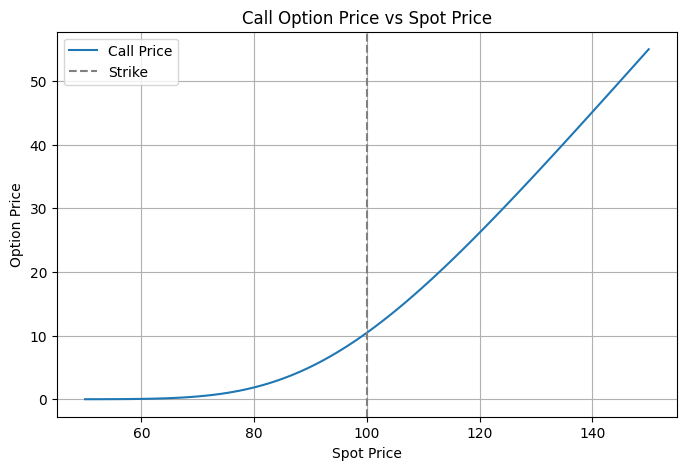

In [13]:
plot_option_vs_spot(K=100, T=1, r=0.05, sigma=0.2, option_type='call')

**Using real market data from Yahoo Finance**

In [14]:
ticker = 'AAPL'
stock = yf.Ticker(ticker)
spot_price = stock.history(period='5d')['Close'][-1]
print(f"Latest {ticker} price: {spot_price:.2f}")

# Create Option
option = EuropeanOption(S=spot_price, K=spot_price, T=0.25, r=0.05, sigma=0.25, option_type='call')
price = option.price()
greeks = option.greeks()

print(f"\nCall Option Price: ${price:.2f}")
print("Greeks:")
for greek, val in greeks.items():
    print(f"{greek}: {val:.4f}")


2025-07-27 00:24:07,601 - INFO - Initialized call option with S=213.8800048828125, K=213.8800048828125, T=0.25, r=0.05, sigma=0.25


Latest AAPL price: 213.88

Call Option Price: $11.97
Greeks:
Delta: 0.5645
Gamma: 0.0147
Vega: 0.4210
Theta: -0.0726
Rho: 0.2719


**Interpretation of Results (Black-Scholes European Call)**

Priced an **European call option** on AAPL using the Black-Scholes model and real market data.

**Inputs:**
- **Spot Price (S):** \$213.88
- **Strike Price (K):** \$213.88 (At-the-Money)
- **Time to Maturity (T):** 0.25 years (3 months)
- **Risk-Free Rate (r):** 5% annually
- **Volatility (σ):** 25% annually



Call Option Price: **\$11.97**

This is the fair theoretical price for the right (but not obligation) to buy AAPL at \$213.88 in 3 months. The option is **at-the-money**, which makes the premium primarily influenced by volatility and time value.


**Greeks Breakdown**

| Greek | Value | Interpretation |
|-------|-------|----------------|
| **Delta** | 0.5645 | For every $1 increase in AAPL, the option gains $0.56. Indicates ~56% exposure to the underlying stock. Useful for **Delta hedging**. |
| **Gamma** | 0.0147 | Gamma shows how much **Delta changes** for a \$1 move in AAPL. Higher near-the-money and close to expiry. Indicates **convexity**. |
| **Vega** | 0.4210 | For every 1% increase in implied volatility, the option gains ~\$0.42. Important for **volatility trading** and exposure. |
| **Theta** | -0.0726 | Option **loses ~7.3 cents per day** due to time decay. Crucial for understanding **decay risk** in long positions. |
| **Rho** | 0.2719 | A 1% rise in interest rates increases option value by ~\$0.27. More relevant for **long-dated options**. |



**Hedging Insight**

- Use **Delta** for directional hedging (e.g., Delta-neutral portfolios).
- Monitor **Gamma** to understand sensitivity of Delta — key for large movements.
- Trade **Vega** if you're positioning on volatility (IV spikes benefit buyers).
- Be aware of **Theta decay** — time works against holders, not writers.
- **Rho** matters in rate-sensitive instruments or macro trading strategies.



**Conclusion:**  
The Black-Scholes model offers a robust framework for pricing and risk management of European options. Understanding the **Greeks** equips traders and analysts to make more informed hedging and speculative decisions based on how options respond to different market conditions.
